## 4.4 カラーマトリクス補正

### この節について

この節では、カラーマトリクス補正を解説します。

この節のの内容はColabノートブックとして公開してあります。ノートブックを見るには[目次ページ](http://bit.ly/raw_toc)から参照するか、以下のリンクを使ってアクセスしてください。

http://bit.ly/raw_4_4

### 準備

まずライブラリーのインストールと、モジュールのインポート、画像の読み込みを行います。今回もラズベリーパイで撮影したチャート画像を使用します。
内容については各節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy;
!pip install imageio;

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 前節までに作成したモジュールのダウンロードとインポート
!if [ ! -f raw_process.py ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/raw_process.py; fi
from raw_process import simple_demosaic, white_balance, black_level_correction, gamma_correction, demosaic, defect_correction

# 日本語フォントの設定
!apt -y install fonts-ipafont-gothic
plt.rcParams['font.family'] = 'IPAPGothic'
# もし日本語が文字化けしている場合`! rm /content/.cache/matplotlib/fontList.json`を実行して、
# Runtime->Restart Runtimeで再実行

# 画像をダウンロードします。
!if [ ! -f chart.jpg ]; then wget https://github.com/moizumi99/camera_raw_processing/raw/master/chart.jpg; fi

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "chart.jpg"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw_array.shape

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 10 not upgraded.


### カラーマトリクスとは

前節までにRAW現像した画像と、JPEG画像を並べて比較してみましょう。
こちらがJPEG画像をJPEGとしてそのまま表示したものです。

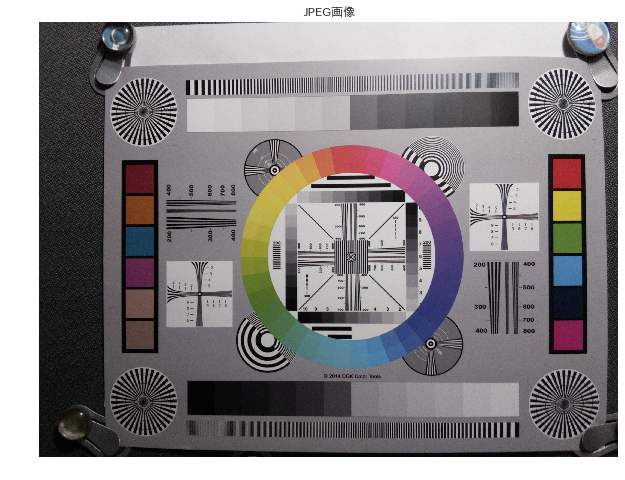

In [2]:
# JPEG画像をnumpyのarrayとして取得
# [4.2節参照](https://colab.research.google.com/github/moizumi99/camera_raw_processing/blob/master/camera_raw_chapter_4_2.ipynb)
from matplotlib import image
import matplotlib
jpg_img = image.imread("chart.jpg")
jpg_img = jpg_img / jpg_img.max()

# JPEG画像表示
plt.figure(figsize=(16, 8))
imshow(jpg_img)
plt.axis('off')
plt.title(u"JPEG画像")
plt.show()

それに対してこちらが、前回までに現像したものです。

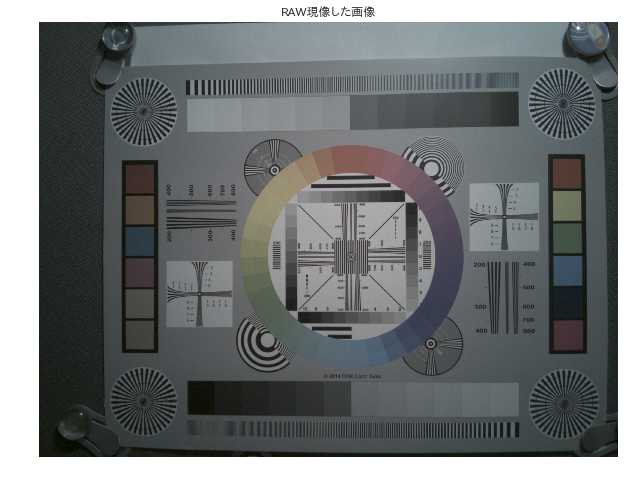

In [3]:
# ブラックレベル補正。
blc_raw = black_level_correction(raw_array, raw.black_level_per_channel, raw.raw_pattern)
# 前節で作成したdefect_correction関数を使って、欠陥画素補正。
dpc_raw = defect_correction(blc_raw, 16)
# 残りの現像処理
wb_raw = white_balance(dpc_raw, raw.camera_whitebalance, raw.raw_colors)
dms_img = demosaic(wb_raw, raw.raw_colors)
# ガンマ処理の前にwhite_levelで正規化
white_level = 1024
dms_img = dms_img / white_level
gmm_img = gamma_correction(dms_img, 2.2)

# 画像表示。
plt.figure(figsize=(16, 8))
imshow(gmm_img)
plt.axis('off')
plt.title(u"RAW現像した画像")
plt.show()

２つの画像を見比べると、色の鮮やかさが違うことがわかると思います。また色合いも完全には一致していません。実際の見た目も最初のJPEGの画像に近くなっています。

どうしてこうなってしまうかというと、最大の原因はカメラのセンサーの色ごとの感度が人間の目とは完全には一致しないことです。例えば人間の目はある光の周波数の範囲を赤、青、緑、と感じるのですが、センサーが緑を検知する範囲は人間が緑と感じる領域とは微妙に異なっています。同じように青や赤の範囲も違います。これは、センサーが光をなるべく沢山取り込むため、だとか、製造上の制限、などの理由があるようです。 さらに、人間の目には、ある色を抑制するような領域まであります。これはセンサーで言えばマイナスの感度があるようなものですが、そんなセンサーは作れません。

こういったセンサー感度と人間の目の間隔とがなるべく小さくなるように、3色を混ぜて、より人間の感覚に近い色を作り出す必要があります。この処理を通常は行列を使って行い、これをカラーマトリクス補正と呼びます。

カラーマトリクス補正というのは処理的には3x3の行列に、3色の値を成分としたベクトルをかけるという処理になります。

$$ 
\left(
    \begin{matrix}
        R_{out} \\
        G_{out} \\
        B_{out} \\
    \end{matrix}
\right) = 
\left(
    \begin{matrix}
        c_0 & c_1 & c_2 \\
        c_3 & c_4 & c_5 \\
        c_6 & c_7 & c_8 \\
    \end{matrix}
\right)
\left(
    \begin{matrix}
        R_{in} \\
        G_{in} \\
        B_{in} \\
    \end{matrix}
\right)
$$

このような処理で、色の深み・鮮やかさ（Saturationと呼ばれます）、色合い（Hueと呼ばれます）をある程度修正することができます。

### カラーマトリクス補正

それでは実際にカラーマトリクス補正をかけてみましょう。

まず、撮影されたRAW画像に保存されているカラーマトリクスの値を読んでみましょう。
RAWPYにもカラーマトリクスを読み取る機能はあるのですが、実際に実行するとこうなってしまいます。

In [4]:
print(raw.color_matrix)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


これでは仕方がないので、exiftoolを使います。exiftoolはコマンドラインから各種画像ファイルの情報を取り出すツールです。

まずcolabの環境にexiftoolをインストールします。

In [5]:
! apt install exiftool

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'libimage-exiftool-perl' instead of 'exiftool'
The following additional packages will be installed:
  libarchive-zip-perl libmime-charset-perl libposix-strptime-perl libsombok3
  libunicode-linebreak-perl
Suggested packages:
  libencode-hanextra-perl libpod2-base-perl
The following NEW packages will be installed:
  libarchive-zip-perl libimage-exiftool-perl libmime-charset-perl
  libposix-strptime-perl libsombok3 libunicode-linebreak-perl
0 upgraded, 6 newly installed, 0 to remove and 10 not upgraded.
Need to get 3,395 kB of archives.
After this operation, 20.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libarchive-zip-perl all 1.60-1ubuntu0.1 [84.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libimage-exiftool-perl all 10.80-1 [3,147 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe a

Exiftoolをつかって、カラーマトリクスの内容を見てみましょう。

Raspberry PiのRAW画像の場合、カラーマトリクスはメーカーノート情報（カメラメーカー独自のデータ）に含まれています[^1]。メーカーノートは`-EXIF:MakerNoteUnknownText -b`オプションで読むことができます。

[^1]: α7IIIのRAW画像ではEXIF情報に含まれているのでオプションをつけなくとも`! exiftool sample.ARW`で読み取ることができます。

In [6]:
! exiftool -EXIF:MakerNoteUnknownText -b chart.jpg -b

ev=-1 mlux=-1 exp=62998 ag=556 focus=255 gain_r=1.128 gain_b=2.546 greenness=3 ccm=6022,-2314,394,-936,4728,310,300,-4324,8126,0,0,0 md=0 tg=262 262 oth=0 0 b=0 f=262 262 fi=0 ISP Build Date: Oct  8 2018, 17:46:45 VC_BUILD_ID_VERSION: 656741eb5ba785fc4f1014a3a3b1c0e9c2cc8487 (clean) VC_BUILD_ID_USER: dc4 VC_BUILD_ID_BRANCH: master 

繋がっていて読みにくいですが、よく見てみるとこのような部分があるのがわかります。

> ccm=6022,-2314,394,-936,4728,310,300,-4324,8126,0,0,0

これは、カラーマトリクス(CCM: Color Correction Matrix)が次のような値であることを示しています。

$$ \left(
    \begin{matrix}
        6022 & -2314 & 394 \\
        -936 & 4728 & 310 \\
        300 & -4324 & 8126 \\
    \end{matrix}
\right) $$

このままでは入力と掛け合わせた時に非常に大きくなってしまうので、何かの値で正規化しなくてはなりません。Exifのメーカーノートには特に記載がありませんが、各行の和が4096に近いので、4096で正規化しておくことにしましょう。

それではこの値を使ってカラーマトリクス補正を行ってみましょう。カラーマトリクス補正は線形な色空間で行う必用があるので、ガンマ補正の前に行います。

In [0]:
# カラーマトリクス
# [[6022,-2314,394]
#  [-936,4728,310]
#  [300,-4324,8126]] / 4096
color_matrix = np.array([[6022,-2314,394],[-936,4728,310],[300,-4324,8126]]) / 4096

# 出力先を作成しておく
ccm_img = np.zeros_like(dms_img)
# 実際に１画素毎に処理
# 入力はデモザイク処理後の画像。
for y in range(0, h):
    for x in range(0, w):
        pixel = dms_img[y, x, :]
        # numpyのdotは行列同士の掛け算を計算する関数
        pixel = np.dot(color_matrix, pixel)
        ccm_img[y, x, :] = pixel

残っているガンマ補正を行います。

In [0]:
ccm_gmm_img = gamma_correction(ccm_img, 2.2)

最終的な画像を表示して、カラーマトリクス補正なしのものと比較してみましょう。

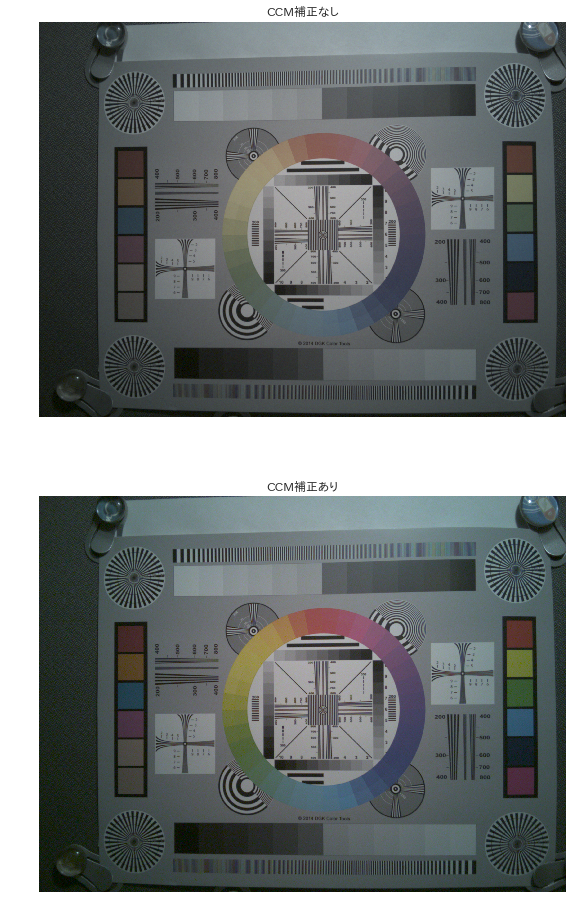

In [9]:
# 表示領域設定
plt.figure(figsize=(12, 16))
# 2 x 1 (縦２，横１)のうち１つめの表示
plt.subplot(2, 1, 1)
# CCM補正なしの画像を表示
plt.imshow(gmm_img)
plt.axis('off')
plt.title(u"CCM補正なし")
# 2 x 1 (縦２，横１)のうち２つめの表示
plt.subplot(2, 1, 2)
# CCM補正ありの画像を表示
plt.imshow(ccm_gmm_img)
plt.axis('off')
plt.title(u"CCM補正あり")
# 画像を描画
plt.show()

CCMありのほうが色が鮮やかになっているのがわかると思います。

### モジュールへの追加

この処理も高速化して、関数としてモジュールへ追加しておきましょう。

In [0]:
def color_correction_matrix(rgb_array, color_matrix):
    """
    カラーマトリクス補正を行う。
    
    Parameters
    ----------
    rgb_array: numpy array
        入力RGB画像
    color_matrix: 2D (3x3) array like
        3x3 Color Correction Matrix
        Need to be normalized to 1.0
    
    Returns
    -------
    ccm_img: numpy array
        出力RGB画像
    """
    
    # 出力先を作成
    ccm_img = np.zeros_like(rgb_array)
    # CCMが3x3フォーマットでない場合、3x3に変換
    ccm = np.array(color_matrix).reshape((3, 3))
    # 各色毎に処理。この方が各画素ごとに処理するよりも高速なようだ。
    for color in (0, 1, 2):
        # 行列と入力画像の各色を掛け合わせる。
        ccm_img[:, :, color] = ccm[color, 0] * rgb_array[:, :, 0] + \
                               ccm[color, 1] * rgb_array[:, :, 1] + \
                               ccm[color, 2] * rgb_array[:, :, 2]
    return ccm_img

この`color_correction_matrix()`関数は`raw_process.py`モジュールの一部として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import color_correction_matrix`

としてインポートしてください。

### まとめ

この節ではカラーマトリクス補正を行いました。次は[レンズシェーディング補正](http://bit.ly/raw_4_5)を行います。